# **Speech Recognition with Voila**

## **About speech recognition**

Speech recognition is a interdisciplinary subfield of computational linguistics that develops methodologies and technologies that enables the recognition and translation of spoken language into text by computers.

## **The model**

The technique which we are going to use here is to convert each wav file to a spectrogram and then to apply image classification techniques. In this example, we are going to use convolutional neural network model with 3 layers. 

## **The dataset**
The dataset which we are using in this example consists 30 classes. Each class includes 2000-2500 audio files (wav).
But, in order to make the model lite we would use only 8 classes out of the 30.

The classes which would be used for thie example: bed, bird, cat, dog, down, six, stop, three.

## **How-to-use**

1) **Trying the data**: the user can try listenting to samples (one from each class) of the dataset by picking a word and then press 'play', when the user pressed the play button - the audio is heard and an image describes the "wave" of the sound appears.

2) **Predicting by recording** : in order to test the model, the user can record himself by clicking 'Record'. Then the record is saved and the user is able to listen to his own recording by clicking 'Play Record'.

3) 

## **Code**

In [493]:
# path = "/data/speech_recog_smaller_ds"
path = "/Users/omerliberman/Desktop/datasets/voice/speech_recog_smaller_ds"

In [494]:
all_classes = ['bed', 'bird', 'cat', 'dog', 'down', 'six', 'stop', 'three']

In [495]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

### **Trying the dataset !**

In [496]:
import os, random
import soundfile as sf
import matplotlib.pyplot as plt

from PIL import Image
from scipy import signal
from scipy.io import wavfile
from ipywidgets import Button, VBox, HBox, GridspecLayout, Layout, RadioButtons, Image, Text, FloatText

In [497]:
# Create samples from all classes.
sub_folders = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith(".cnvrg")]

random_files = []
for sub_folder in sub_folders:
    rand_file = random.choice([file for file in os.listdir(sub_folder) if file.endswith('.wav')])
    label = sub_folder.split('/')[-1]
    random_files.append((sub_folder + "/" + rand_file, label))

In [498]:
def get_single_spectrogram(path_to_wav, spectrogram_path):
    samplingFrequency, signalData = wavfile.read(path_to_wav)
    spectrogram = plt.plot(signalData)
    plt.axis('off')
    plt.savefig(spectrogram_path, bbox_inches='tight')

In [499]:
def play_sound_and_create_spectrogram(_=None):
    path_of_wav_to_play = [aud for aud in random_files if aud[1] == trying_audio_wid.value][0][0]    
    data, fs = sf.read(path_of_wav_to_play, dtype='float32')
    sd.play(data, fs)
    
    spectrogram_img = get_single_spectrogram(path_of_wav_to_play, "sample_spectrogram.png")
    file = open("sample_spectrogram.png", "rb")
    image = file.read()
    spectrogram_wid.value = image

In [500]:
# Selection word button.
trying_audio_wid = RadioButtons(options=all_classes,
                                value=all_classes[0],
                                description='Word:',
                                disabled=False)

In [501]:
# Playing word button.
play_button = Button(description='Play', layout={'width': '100px'})
play_button.on_click(play_sound_and_create_spectrogram)

In [502]:
# Spectrogram image widget.
file = open("white.png", "rb")
image = file.read()
spectrogram_wid = Image(value=image,
                        format='png',
                        width=100,
                        height=100)

In [503]:
# Grouping the play button and the spectrogram.
vb_of_play_and_spectrogram = VBox([play_button, spectrogram_wid])

In [504]:
# Grouping all the widgets.
HBox([trying_audio_wid, vb_of_play_and_spectrogram])

### **Record yourself !**

In [505]:
import sounddevice as sd

from time import sleep
from scipy.io.wavfile import write

In [506]:
def record_user(_=None):
    fs = 16000  # Sample rate
    seconds = 1.2  # Duration of recording
    status_wid.value = "Recording..."
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()
    write('user_recording.wav', fs, myrecording)
    status_wid.value = "Recorded"

In [507]:
# Record user button.
record_button = Button(description='Record')
record_button.on_click(record_user)

In [508]:
def play_user_recording(_=None):
    status_wid.value = "Playing..."
    data, fs = sf.read('user_recording.wav', dtype='float32')
    sd.play(data, fs)
    
    sleep(3)
    status_wid.value = status_wid.placeholder

In [509]:
# Play user's record button.
play_recorded_button = Button(description='Play record')
play_recorded_button.on_click(play_user_recording)

In [510]:
hb = HBox([record_button, play_recorded_button])

In [511]:
# text widget status.
status_wid = Text(placeholder='Record yourself !', disabled=True)

In [512]:
vb = VBox([hb, status_wid])

vb

### **Use the model to predict your record**

In [513]:
import json
import numpy as np

from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [514]:
model = load_model('CNN_Model.h5')

dict_of_labels = None
with open('labels_dictionary.json') as f:
    dict_of_labels = json.load(f)
    
dict_of_labels

{'cat': 0,
 'bed': 1,
 'dog': 2,
 'stop': 3,
 'three': 4,
 'bird': 5,
 'down': 6,
 'six': 7}

In [515]:
def make_prediction(_=None):
    # Preparing the recorded file for prediction.
    wav_file_to_predict = 'user_recording.wav'

    get_single_spectrogram(wav_file_to_predict, 'img_to_predict.png')

    image = load_img('img_to_predict.png', target_size=(200, 200))

    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    
    # Insert the results to their true places.
    prediction_vec = model.predict(image)
    
    label_of_pred = np.argmax(prediction_vec)
    pred_prob = prediction_vec[0][label_of_pred]
    
    literal_label = [item[0] for item in dict_of_labels.items() if item[1] == label_of_pred][0]
    
    prediction_wid.value = literal_label
    prob_wid.value = pred_prob

In [516]:
predict_button = Button(description='Predict', layout={'width': '300px'})
predict_button.on_click(make_prediction)

In [517]:
# text widget which is going to include to prediction label.
prediction_wid =  Text(description='Prediction: ', placeholder='Prediction', disabled=True)
# text widget which is going to include to prediction probability.
prob_wid =  FloatText(description='Probability: ', placeholder=0.0, disabled=True)

vb_pred_and_prob = VBox([prediction_wid, prob_wid])

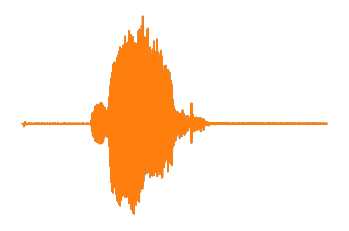

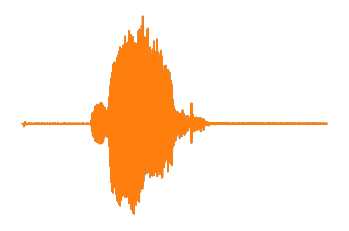

In [518]:
vb_prediction = VBox([predict_button, vb_pred_and_prob])

vb_prediction